### 1 正则化线性回归

先对一个水库的流出水量以及水库水位进行正则化线性回归，并探讨方差-偏差的问题

### 1.1 数据可视化

In [39]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
data = sio.loadmat('./datasets/ex5data1.mat')
X, y, Xval, yval, Xtest, ytest = map(np.ravel,[data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']])
X.shape, y.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape

((12,), (12,), (21,), (21,), (21,), (21,))

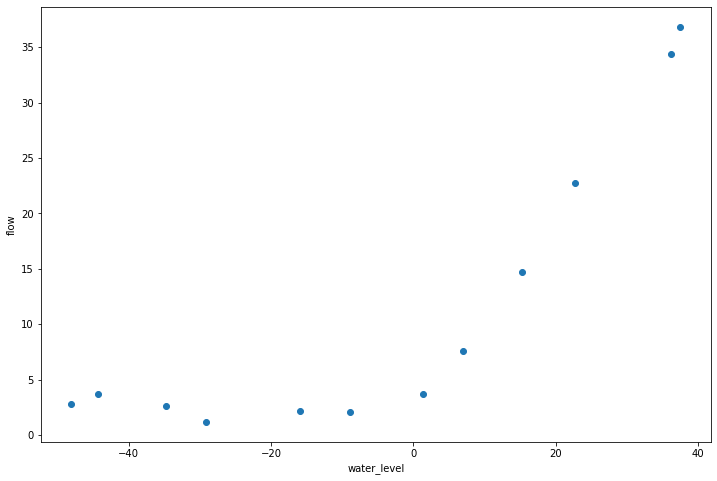

In [41]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X, y)
ax.set_xlabel('water_level')
ax.set_ylabel('flow')
plt.show()

### 1.2 正则化线性回归代价函数

In [42]:
# 在第一列添加1
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

In [43]:
# 计算代价函数
def cost(theta, X, y):
    m = X.shape[0]
    
    inner = X @ theta - y    
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)
    
    return cost

In [44]:
# 加入正则化项的代价函数
def costReg(theta, X, y, reg=1):
    m = X.shape[0]
    
    regularized_term = (reg / (2 * m)) * np.power(theta[1:], 2).sum()
    
    return cost(theta, X, y) + regularized_term

In [45]:
theta = np.ones(X.shape[1])
costReg(theta, X, y, 1)

303.9931922202643

### 1.3 正则化线性回归梯度

In [46]:
# 梯度下降
def gradient(theta, X, y):
    m = X.shape[0]
    
    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)
    
    return inner / m

In [47]:
# 加入正则项的梯度下降
def gradientReg(theta, X, y, reg):
    m = X.shape[0]
    
    # 拷贝和theta相同的shape     
    regularized_term = theta.copy() 
    regularized_term[0] = 0
    
    regularized_term = (reg / m) * regularized_term
    
    return gradient(theta, X, y) + regularized_term

In [48]:
gradientReg(theta, X, y, 1)

array([-15.30301567, 598.25074417])

### 1.4 拟合线性回归

In [49]:
# 调用工具库找到θ最优解
theta = np.ones(X.shape[1])
final_theta = opt.minimize(fun=costReg, x0=theta, args=(X, y, 0), method='TNC', jac=gradientReg, options={'disp': True}).x
final_theta

array([13.08790348,  0.36777923])

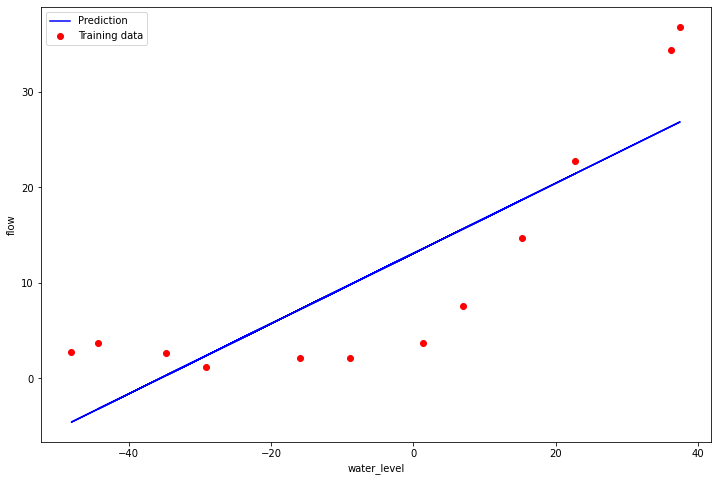

In [50]:
# 截距
b = final_theta[0]
m = final_theta[1]

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(X[:, 1], y, c='r', label="Training data")
plt.plot(X[:, 1], X[:, 1]*m + b, c='b', label="Prediction")
ax.set_xlabel('water_level')
ax.set_ylabel('flow')
ax.legend()
plt.show()

### 2 方差和偏差

偏差较大的模型会欠拟合，
方差较大的模型会过拟合

In [51]:
def linear_regression(X, y, l=1):
    theta = np.ones(X.shape[1])
    
    res = opt.minimize(fun=costReg,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=gradientReg,
                       options={'disp': True})
    return res

In [52]:
training_cost, cv_cost = [], []

In [53]:
# 计算误差随样本数目的变化
m = X.shape[0]
for i in range(1, m+1):
    res = linear_regression(X[:i, :], y[:i], 0)
    
    tc = costReg(res.x, X[:i, :], y[:i], 0)
    cv = costReg(res.x, Xval, yval, 0)
    
    training_cost.append(tc)
    cv_cost.append(cv)

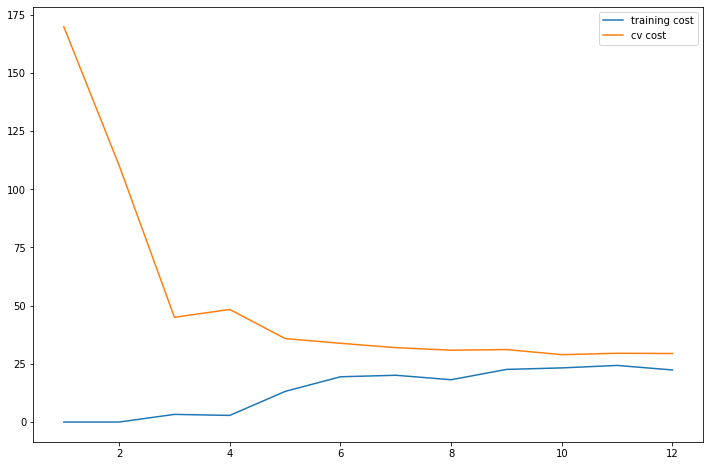

In [54]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend()
plt.show()

### 3 多项式回归

In [55]:
# 添加更多的特征，多项式回归
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)
    
    return df.values if as_ndarray else df

In [56]:
data = sio.loadmat('./datasets/ex5data1.mat')
X, y, Xval, yval, Xtest, ytest = map(np.ravel,[data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']])
X.shape, y.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape

((12,), (12,), (21,), (21,), (21,), (21,))

In [58]:
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


### 3.1 多项式回归

In [59]:
# 获取误差，均值，标准化数据
def normalize_feature(df):
    """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [60]:
def prepare_poly_data(*args, power):
    
    def prepare(x):
        df = poly_features(x, power=power)
        
        ndarr = normalize_feature(df).values
        
        # 加入截距项         
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)
    
    return [prepare(x) for x in args]

In [61]:
X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X, Xval, Xtest, power=8)
X_poly[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

In [62]:
# 画出学习曲线
def plot_learning_curve(X, Xinit, y, Xval, yval, l=0):
    
    training_cost, cv_cost = [], []
    m = X.shape[0]
    
    for i in range(1, m + 1):
        res = linear_regression(X[:i, :], y[:i], l=l)
        
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)
        
        training_cost.append(tc)
        cv_cost.append(cv)
    
    fig, ax = plt.subplots(2,  1, figsize=(12, 12))
    ax[0].plot(np.arange(1, m + 1), training_cost, label='training cost')
    ax[0].plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    ax[0].legend()
    
    fitx = np.linspace(-50, 50, 100) 
    fitxtmp = prepare_poly_data(fitx, power=8)
    fity = np.dot(prepare_poly_data(fitx, power=8)[0], linear_regression(X, y, l).x.T)
    
    ax[1].plot(fitx, fity, c='r', label='fitcurve')
    ax[1].scatter(Xinit, y, c='b', label='initial_Xy')
    
    ax[1].set_xlabel('water_level')
    ax[1].set_ylabel('flow')    

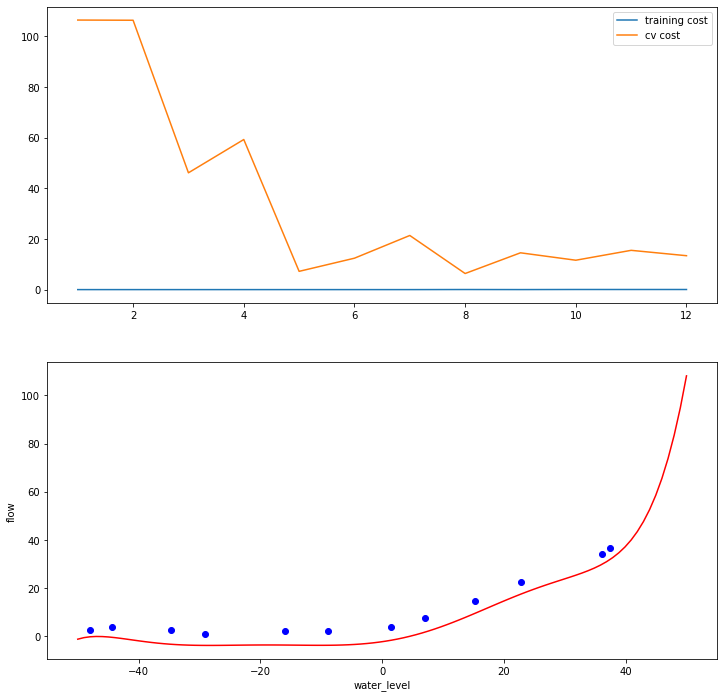

In [63]:
plot_learning_curve(X_poly, X, y, Xval_poly, yval, l=0)
plt.show()

### 3.2 调整正则化系数λ

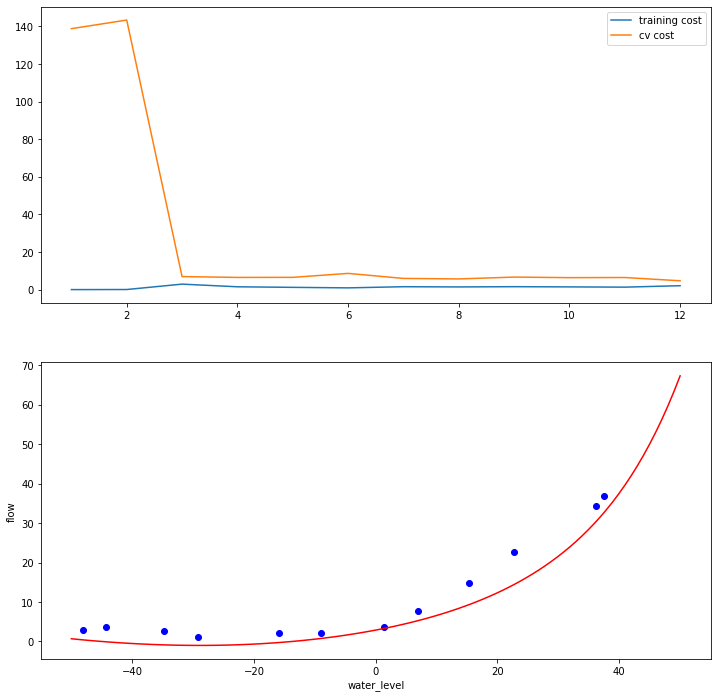

In [64]:
# λ=1
plot_learning_curve(X_poly, X, y, Xval_poly, yval, l=1)
plt.show()

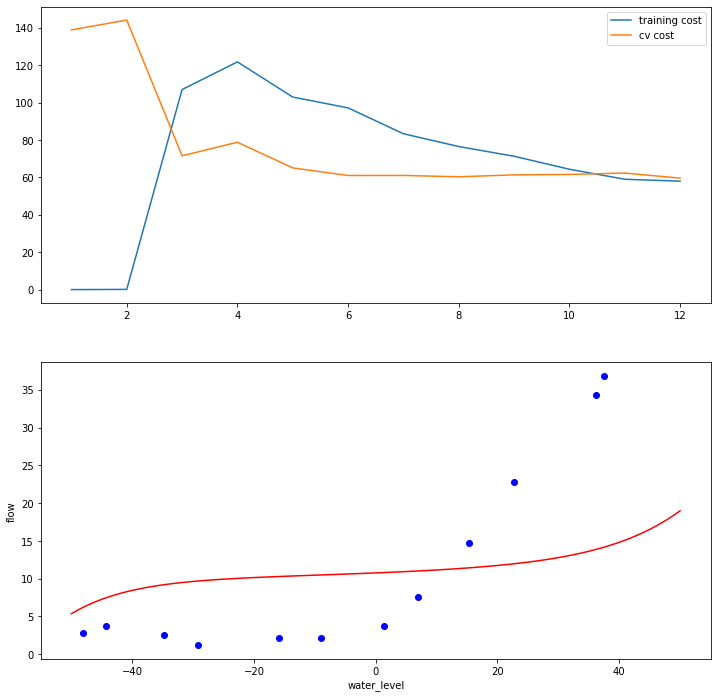

In [65]:
# λ=100（欠拟合）
plot_learning_curve(X_poly, X, y, Xval_poly, yval, l=100)
plt.show()

### 3.3 找到最佳的λ

In [66]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [67]:
for l in l_candidate:
    res = linear_regression(X_poly, y, l)
    
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)
    
    training_cost.append(tc)
    cv_cost.append(cv)

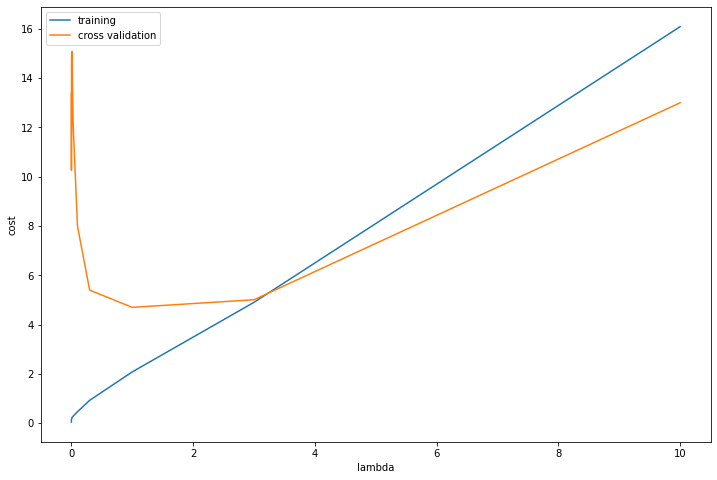

In [68]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(l_candidate, training_cost, label='training')
ax.plot(l_candidate, cv_cost, label='cross validation')
plt.legend()

plt.xlabel('lambda')

plt.ylabel('cost')
plt.show()

### 3.4 计算测试集上的误差

In [69]:
# use test data to compute the cost
for l in l_candidate:
    theta = linear_regression(X_poly, y, l).x
    print('test cost(l={}) = {}'.format(l, cost(theta, Xtest_poly, ytest)))

test cost(l=0) = 10.122298845834932
test cost(l=0.001) = 10.989357236615056
test cost(l=0.003) = 11.26731092609127
test cost(l=0.01) = 10.881623900868235
test cost(l=0.03) = 10.02232745596236
test cost(l=0.1) = 8.632062332318977
test cost(l=0.3) = 7.336513212074589
test cost(l=1) = 7.466265914249742
test cost(l=3) = 11.643931713037912
test cost(l=10) = 27.7150802906621
